In [0]:

# from __future__ import print_function, division
import os
import sys
import torch
import torch.nn as nn
# import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import cv2

# from __future__ import print_function, division

import pandas as pd
# import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob
from skimage import io

from torch.utils.data import Dataset

from torch.autograd import Function
from torch.nn.modules.distance import PairwiseDistance
from tqdm import tqdm
from PIL import Image

import torch.nn.functional as F
# import torch.optim as optim
# import torchvision
# from torchvision import datasets, transforms
from torch. utils.data import DataLoader


In [0]:

from IPython.display import clear_output
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tJpao4hjQE97b6XdDY9zD5i05xMU_2RJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1tJpao4hjQE97b6XdDY9zD5i05xMU_2RJ" -O face_mask_dataset.7z && rm -rf /tmp/cookies.txt
clear_output()

In [4]:
!apt-get install p7zip-full


!p7zip -d face_mask_dataset.7z
clear_output()

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/face_mask_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
print(class_names)

['with_mask', 'without_mask']


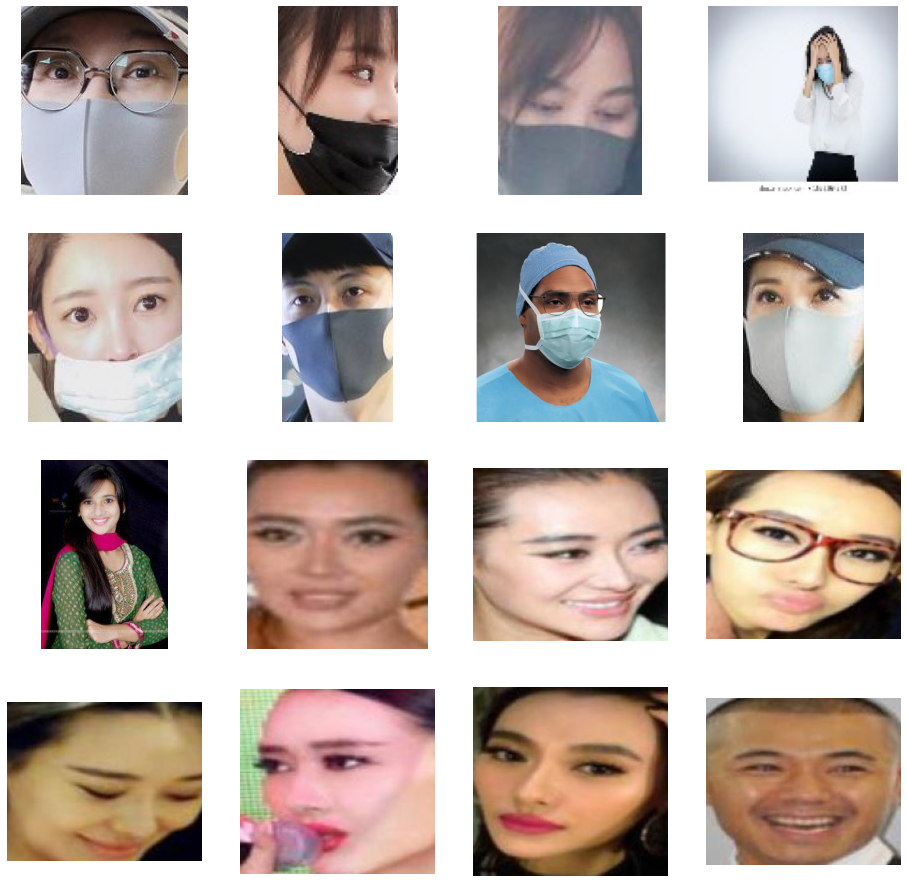

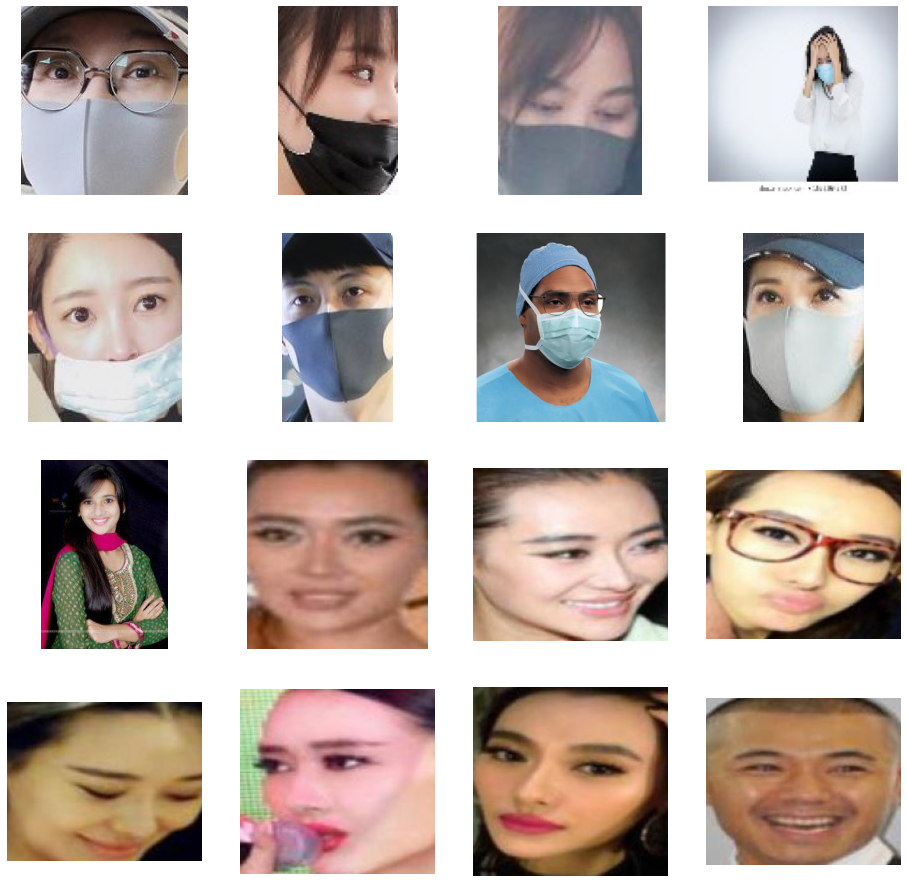

In [7]:
base_dir = '/content/face_mask_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_mask_dir = os.path.join(train_dir, 'with_mask')

# Directory with our training dog pictures
train_nomask_dir = os.path.join(train_dir, 'without_mask')

# Directory with our validation cat pictures
validation_mask_dir = os.path.join(validation_dir, 'with_mask')

# Directory with our validation dog pictures
validation_nomask_dir = os.path.join(validation_dir, 'without_mask')
train_mask_fnames = os.listdir(train_mask_dir)

# print(train_mask_fnames[:10])

train_nomask_fnames = os.listdir(train_nomask_dir)
train_nomask_fnames.sort()
# print(train_nomask_fnames[:10])
# Set up matplotlib fig, and size it to fit 4x4 pics
%matplotlib inline


# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
# train_mask_dir="/content/face_mask_dataset/train"

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_mask_pix = [os.path.join(train_mask_dir, fname) 
                for fname in train_mask_fnames[pic_index-8:pic_index]]
next_nomask_pix = [os.path.join(train_nomask_dir, fname) 
                for fname in train_nomask_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_mask_pix+next_nomask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_mask_dir = os.path.join(train_dir, 'with_mask')

# Directory with our training dog pictures
train_nomask_dir = os.path.join(train_dir, 'without_mask')

# Directory with our validation cat pictures
validation_mask_dir = os.path.join(validation_dir, 'with_mask')

# Directory with our validation dog pictures
validation_nomask_dir = os.path.join(validation_dir, 'without_mask')
train_mask_fnames = os.listdir(train_mask_dir)

# print(train_mask_fnames[:10])

train_nomask_fnames = os.listdir(train_nomask_dir)
train_nomask_fnames.sort()
# print(train_nomask_fnames[:10])
# Set up matplotlib fig, and size it to fit 4x4 pics
%matplotlib inline


# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
# train_mask_dir="/content/face_mask_dataset/train"

# Index for iterating over images
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_mask_pix = [os.path.join(train_mask_dir, fname) 
                for fname in train_mask_fnames[pic_index-8:pic_index]]
next_nomask_pix = [os.path.join(train_nomask_dir, fname) 
                for fname in train_nomask_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_mask_pix+next_nomask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [9]:
# https://drive.google.com/file/d/1pEsDv_saO3tz9Vf7aRC56vjaz6tgOkjp/view?usp=sharing
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pEsDv_saO3tz9Vf7aRC56vjaz6tgOkjp' -O mask_classifier.pth 
# model_ft = torch.load("mask_classifier.pth",map_location=torch.device('cpu'))
model_ft = torch.load("mask_classifier.pth")

--2020-06-06 15:43:30--  https://docs.google.com/uc?export=download&id=1pEsDv_saO3tz9Vf7aRC56vjaz6tgOkjp
Resolving docs.google.com (docs.google.com)... 74.125.203.101, 74.125.203.138, 74.125.203.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.203.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1jvcusf52opq70g5tfhomle1aabt8ahp/1591458150000/01693442760845217088/*/1pEsDv_saO3tz9Vf7aRC56vjaz6tgOkjp?e=download [following]
--2020-06-06 15:43:32--  https://doc-00-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1jvcusf52opq70g5tfhomle1aabt8ahp/1591458150000/01693442760845217088/*/1pEsDv_saO3tz9Vf7aRC56vjaz6tgOkjp?e=download
Resolving doc-00-68-docs.googleusercontent.com (doc-00-68-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-00-68-docs.googleusercontent.com (doc-00-68-d

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
from IPython.display import clear_output

!wget https://github.com/RufinaMay/CV2019Fall_Pictures/raw/master/deploy.prototxt.txt
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/raw/master/res10_300x300_ssd_iter_140000.caffemodel
clear_output()

In [0]:
dir="/home/hafeez/Desktop/face_mask/face_mask_dataset/"
image = cv2.imread(dir+"passport_hafeez.jpg",cv2.IMREAD_COLOR)


In [0]:

def read_and_resize_image(filename, grayscale = False, fx= 1, fy=1):
  if grayscale:
    img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  else:
    imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
    img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
  img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
  return img_result
  
def showInRow(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

In [0]:
# dir="/home/hafeez/Desktop/face_mask/"

# prototxtPath = os.path.sep.join([dir, "deploy.prototxt.txt"])
# weightsPath = os.path.sep.join([dir, "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNetFromCaffe('deploy.prototxt.txt', 'res10_300x300_ssd_iter_140000.caffemodel')


In [0]:
model_ft = torch.load("mask_classifier.pth")
class_names = ['with_mask',
 'without_mask'
]
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    # pil_image = Image.open(image)
    #pil_image = image
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)

    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = image_transforms(im_pil)
    return img
def classify_face(image_path):

    device = torch.device("cpu")
    img = process_image(image_path)
    print('image_processed')
    img = img.unsqueeze_(0)
    img = img.float()

    model_ft.eval()
    # model_ft
    output = model_ft(img)
    print(output,'##############output###########')
    _, predicted = torch.max(output, 1)
    print(predicted.data[0],"predicted")


    classification1 = predicted.data[0]
    index = int(classification1)
    print(class_names[index])
    return class_names[index]

(1, 1, 200, 7)


In [0]:
model_ft = models.mobilenet_v2(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Sequential(
                      nn.Linear(num_ftrs, 2),
                      nn.Sigmoid())
                      # nn.Sigmoid(), 
                      # nn.Dropout(0.4),
                      # nn.Linear(256, 64),
                      # nn.Sigmoid(),
                      # nn.Linear(64,2),
                      # nn.Softmax())
# print(model_ft)
# models.mobmodel_ft.eval()
model_dict= torch.load("mask_classifier.pth",map_location=torch.device('cpu'))

model_ft.load_state_dict(model_dict)
clear_output()

In [0]:
# model_ft = models.resnet18(pretrained=True)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

<All keys matched successfully>

(1, 1, 200, 7)
image_processed
tensor([[0.6618, 0.3189]], grad_fn=<SigmoidBackward>) ##############output###########
tensor(0) predicted
with_mask


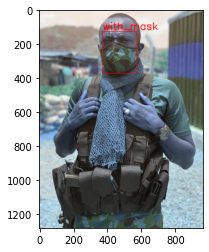

In [18]:


# img_pulp = read_and_resize_image("passport_hafeez.jpg", grayscale = False, fx= 1, fy=1)
# img_pulp_copy= img_pulp.copy()
# dir="/home/hafeez/Desktop/face_mask/face_mask_dataset/"
# file = "/home/hafeez/Desktop/face_mask/face_mask_dataset/test_img/passport_hafeez.jpg"
file = "photo1.jpg"
image = cv2.imread(file,cv2.IMREAD_COLOR)

# dir="/home/hafeez/Desktop/face_mask/"

# prototxtPath = os.path.sep.join([dir, "deploy.prototxt.txt"])
# weightsPath = os.path.sep.join([dir, "res10_300x300_ssd_iter_140000.caffemodel"])
# net = cv2.dnn.readNet(prototxtPath, weightsPath)

# net = cv2.dnn.readNetFromCaffe('deploy.prototxt.txt', 'res10_300x300_ssd_iter_140000.caffemodel')
confidence = 0.5
#  class_names = ['with_mask',
#  'without_mask'
# ]
# image = cv2.imread("rufai.jpg")
img_pulp = image.copy()

(h, w) = img_pulp.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0), swapRB = False)
 
net.setInput(blob)
detections = net.forward()
faces=[]
  # filter out weak detections
print(detections.shape)


for i in range(0,detections.shape[2]):
  confidence = detections[0, 0, i, 2]
 
  if confidence > 0.50:
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    (startX, startY) = (max(0, startX), max(0, startY))
    (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

    face = (startX, startY, endX-startX, endY-startY)
    face = image[startY:endY, startX:endX]
    # showInRow([])
    label =classify_face(face)
    # print(label)
    color = (0, 255, 0) if label == "with mask" else (255, 0, 0)
    # if label =="with mask":
    cv2.rectangle(img_pulp, (startX, startY), (endX, endY), color, 2)
    cv2.putText(img_pulp, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 2, color, 4)
    # else:
      # cv2.putText(img_pulp, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
      # cv2.rectangle(img_pulp, (startX, startY), (endX, endY), color, 2)    
showInRow([img_pulp])

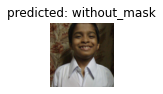

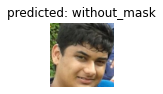

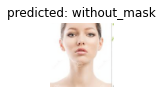

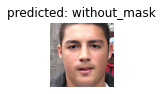

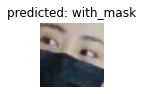

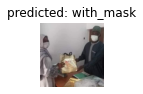

In [19]:
def visualize_model(model, num_images=6):
    # was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            # inputs = inputs.to(device)
            # labels = labels.to(device)

            outputs = model(inputs)
            # print(outputs)
            _, preds = torch.max(outputs, 1)
            # print(preds)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    # model.train(mode=was_training)
                    return
        # model.train(mode=was_training)
# torch.save(model_ft.state_dict(), "mask_classifier.pth")
# model_ft = model_ft.to(device)
    
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

visualize_model(model_ft)

plt.ioff()
plt.show()